To enable GPU:
Runtime -> Change runtime type -> GPU

In [1]:
! pip install onnxruntime
! pip install openvino
! pip install huggingface_hub
! pip install git+https://github.com/parlance/ctcdecode
! pip install pyclipper

! git clone https://github.com/ai-forever/SEGM-model.git
! git clone https://github.com/ai-forever/OCR-model.git
! git clone https://github.com/ai-forever/ReadingPipeline.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 32.5 MB/s 
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 86 kB 6.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.8 MB 2.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 17.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/parlance/ctcdecode to /tmp/pip-req-build-hppylw0f
  Running command git clone -q https://github.com/parlance/ctcdecode /tmp/pip-req-build-hppylw0f
  Running command git submodule update --init --recursive -q
  Created wheel for ctcdecode: filename=ctcdecode-1.0.3-cp37-cp37m-linux_x86_64.w

In [2]:
import sys
sys.path.append('SEGM-model/')
sys.path.append('OCR-model/')
sys.path.append('ReadingPipeline/')

import cv2
from matplotlib import pyplot as plt
import numpy as np
import json

from huggingface_hub import hf_hub_download

from ocrpipeline.predictor import PipelinePredictor
from ocrpipeline.linefinder import get_structured_text

In [3]:
def get_config_and_download_weights(repo_id, device='cuda'):
    # download weights and configs
    pipeline_config_path = hf_hub_download(repo_id, "pipeline_config.json")
    ocr_model_path = hf_hub_download(repo_id, "ocr/ocr_model.ckpt")
    ocr_config_path = hf_hub_download(repo_id, "ocr/ocr_config.json")
    segm_model_path = hf_hub_download(repo_id, "segm/segm_model.ckpt")
    segm_config_path = hf_hub_download(repo_id, "segm/segm_config.json")

    # change paths to downloaded weights and configs in main pipeline_config
    with open(pipeline_config_path, 'r') as f:
        pipeline_config = json.load(f)

    pipeline_config['main_process']['SegmPrediction']['model_path'] = segm_model_path
    pipeline_config['main_process']['SegmPrediction']['config_path'] = segm_config_path
    pipeline_config['main_process']['SegmPrediction']['num_threads'] = 4
    pipeline_config['main_process']['SegmPrediction']['device'] = device
    pipeline_config['main_process']['SegmPrediction']['runtime'] = "Pytorch"

    pipeline_config['main_process']['OCRPrediction']['model_path'] = ocr_model_path
    pipeline_config['main_process']['OCRPrediction']['config_path'] = ocr_config_path
    pipeline_config['main_process']['OCRPrediction']['num_threads'] = 4
    pipeline_config['main_process']['OCRPrediction']['device'] = device
    pipeline_config['main_process']['OCRPrediction']['runtime'] = "Pytorch"

    # save pipeline_config
    with open(pipeline_config_path, 'w') as f:
        json.dump(pipeline_config, f)

    return pipeline_config_path

# Download weights and initialize the pipeline

In [4]:
PIPELINE_CONFIG_PATH = get_config_and_download_weights("sberbank-ai/ReadingPipeline-Peter")

predictor = PipelinePredictor(pipeline_config_path=PIPELINE_CONFIG_PATH)

Downloading:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/50.2M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Download and show the demo image

Downloading:   0%|          | 0.00/1.90M [00:00<?, ?B/s]

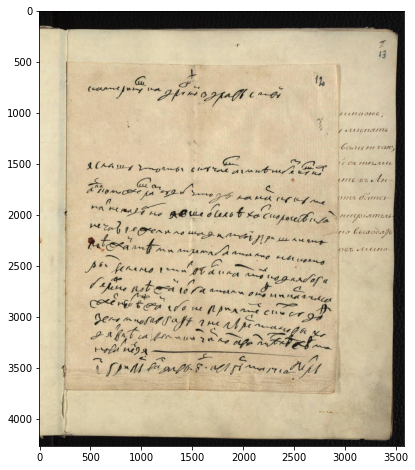

In [5]:
img_path = hf_hub_download("sberbank-ai/ReadingPipeline-Peter", "0_0.jpg")

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()

# Predict
and get text from the image

In [6]:
image = cv2.imread(img_path)
rotated_image, pred_data = predictor(image)

In [7]:
structured_text = get_structured_text(pred_data, ['shrinked_text'])

result_text = [' '.join(line_text) for page_text in structured_text
                for line_text in page_text]

for line in result_text:
    print(line)

+
катеринушка друг мой здравъствуй
я слышу что ты скучаеш а i мнѣ не безкушно ж
аднако можеш разсудит что дѣла на скуку ме
нят не надобно я еше отсель ѣхат скоро себѣ к вам
не чаю i ежели лошади твоi пришли то
поѣжай тѣми тремя баталионы кото
рым велено iтит въ анклам толко для бога
бережно поѣжай i от баталионоф ни на ста са
жен не отѣжжай iбо неприятелских судоф
зело многа в гафѣ i непърестано выхо
дят в лѣса великим числом а вам тѣх лѣсоф ми
новат нелзя
iз грипъсвалда въ 8 д авъгуста 1712 петръ
